In [27]:
## notebook to generate the figures for the paper
import numpy as np
import matplotlib.pyplot as plt
from natsort import natsorted
import bead_utils as bu
import os, glob, re, importlib, numbers, pickle
import scipy.optimize as opt
import scipy.signal as sig
from matplotlib.backends.backend_pdf import PdfPages
from scipy.ndimage import gaussian_filter1d
from matplotlib.patches import Rectangle
from matplotlib.transforms import Bbox


Plot of charge changes over time:

In [28]:
## cycle through all file labels and collect the charge change data
file_label_list = ['20230925', "20231004", "20231009", "20231030", "20231030_2", "20231121"]
code_path = "/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/decay_analysis"

all_charge_changes = []
for file_label in file_label_list:
    data_dir = os.path.join(code_path, "data", file_label)
    charge_data = np.load(data_dir+"/charge_data_%s.npz"%file_label)
    for k in charge_data.keys():
        exec("%s = charge_data['%s']"%(k,k))

    if(len(all_charge_changes) == 0):
        all_charge_changes = good_change_list[:,1]
    else:
        all_charge_changes = np.concatenate((all_charge_changes, good_change_list[:,1]))

print(len(all_charge_changes))

257


In [29]:
file_label = "20231121"
data_dir = os.path.join(code_path, "data", file_label)
charge_data = np.load(data_dir+"/charge_data_%s.npz"%file_label)
for k in charge_data.keys():
    exec("%s = charge_data['%s']"%(k,k))

In [30]:
## fit half-life
def lfun(t, N0, t12, tot_time=tot_livetime, use_norm=True, dead_period_edges=all_bad_periods):
    tint = np.linspace(0, tot_time, 1000)
    norm = np.trapz(0.5**(tint/t12), tint)
    if(use_norm):
        val = 1/norm * 0.5**(t/t12)
    else:
        val = N0 * 0.5**(t/t12)
    bad_pts = np.zeros_like(t)
    for dp in dead_period_edges:
        inrange = ((t > dp[0]) & (t < dp[1]))
        bad_pts = np.logical_or(bad_pts, inrange)
    val[bad_pts] = 0
    return val

def nll(t, N0, t12, tot_time=tot_livetime):
    N = len(t)
    mu = N0*(1 - 0.5**(tot_time/t12))
    poiss = N*np.log(mu) - mu
    return -np.sum(np.log(lfun(t, 1, t12))) - poiss

## time of decays/half life
decay_times = good_change_list[:,0]

## likelihood fit
N0_vec = np.linspace(0, 150, 210)
t12_vec = np.linspace(0.5, 25, 200)
nll_mat_all = np.zeros((len(N0_vec), len(t12_vec)))

for i,N0 in enumerate(N0_vec):
    for j,t12 in enumerate(t12_vec):
        nll_mat_all[i,j] = nll(decay_times, N0, t12)

nll_mat_all -= np.min(nll_mat_all)

t12_true = 10.6 ## https://www.nndc.bnl.gov/nudat3/DecayRadiationServlet?nuc=212Pb&unc=NDS

nlls = [nll_mat_all,] # nll_mat_big]
labs = ["Fit to all reconstructed decays", "Fit to decays $>6$ $e$"]

params_from_profile = []
for j in range(1):
    
    N0_mesh, t12_mesh = np.meshgrid(N0_vec, t12_vec)
    profile = np.zeros_like(t12_vec)
    profile_nll = np.zeros_like(t12_vec)
    for k in range(len(t12_vec)):
        profile[k] = N0_vec[np.argmin(nlls[j][:,k])]
        profile_nll[k] = 2*np.min(nlls[j][:,k])

    cup = np.where((profile_nll <= 1) & (np.roll(profile_nll,-1) > 1))[0]
    clo = np.where((profile_nll <= 1) & (np.roll(profile_nll,1) > 1))[0]
    cv, uv, lv = t12_vec[np.argmin(profile_nll)], t12_vec[cup], t12_vec[clo]
    min_loc = np.argmin(nlls[j].T)
    bpN0, bpt12 = np.ndarray.flatten(N0_mesh)[min_loc], np.ndarray.flatten(t12_mesh)[min_loc]
    bpN0_lo, bpt12_lo = profile[clo], t12_vec[clo]
    bpN0_hi, bpt12_hi = profile[cup], t12_vec[cup]
    params_from_profile.append([bpN0, bpt12, bpN0_lo, bpt12_lo, bpN0_hi, bpt12_hi])

decay_times_list = [decay_times,]
bins = np.linspace(0, 80, 21)
for j in range(1):
    hh,be = np.histogram(decay_times_list[j], bins=bins)
    bc = be[:-1] + np.diff(be)/2

    bin_length = be[1]-be[0]

hh_for_plot = 1.0*hh
bc_for_plot = 1.0*bc

/var/folders/35/ft5fljg94_x6xpzhzn_wtctr0000gn/T/ipykernel_68074/1640375024.py:19: RuntimeWarning: divide by zero encountered in log
  poiss = N*np.log(mu) - mu


/var/folders/35/ft5fljg94_x6xpzhzn_wtctr0000gn/T/ipykernel_68074/3202417518.py:4: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  countour_vals = cs.collections[0].get_paths()[0].vertices


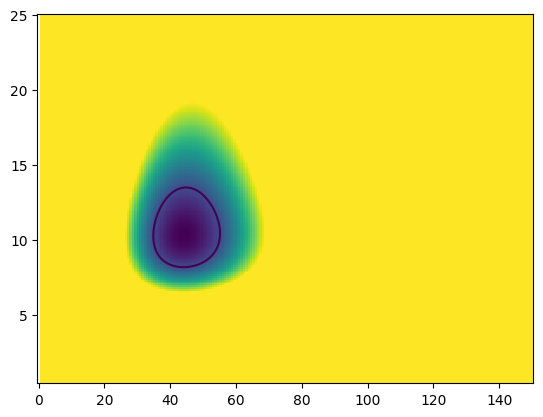

In [31]:
plt.figure()
plt.pcolormesh(N0_vec, t12_vec, 2*nlls[0].T, vmin=0, vmax=10)
cs = plt.contour(N0_vec, t12_vec, 2*nlls[0].T, levels=[2.3])
countour_vals = cs.collections[0].get_paths()[0].vertices

In [32]:
from scipy.stats import lognorm

def gauss(x, A, mu, sig):
    return A*np.exp(-(x-mu)**2/(2*sig**2))

def multigauss(x, A1, m1, s1, A2, m2, s2, sh):
    return gauss(x, A1, m1, s1) + A2*lognorm.pdf((x-m2)/s2, sh)

/var/folders/35/ft5fljg94_x6xpzhzn_wtctr0000gn/T/ipykernel_68074/3637979803.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  inset_ax.set_xticklabels(['2.0', '', '3.0', '', '4.0', '', '5.0'])


best fit is:  [44.49760765550239, 10.34924623115578, array([43.77990431]), array([8.8718593]), array([44.49760766]), array([12.1959799])]
10.34924623115578 [1.47738693] [1.84673367]
Best fit gauss mean:  1.8276012088710407 0.16893298126422698
Second peak location:  8.348348348348349


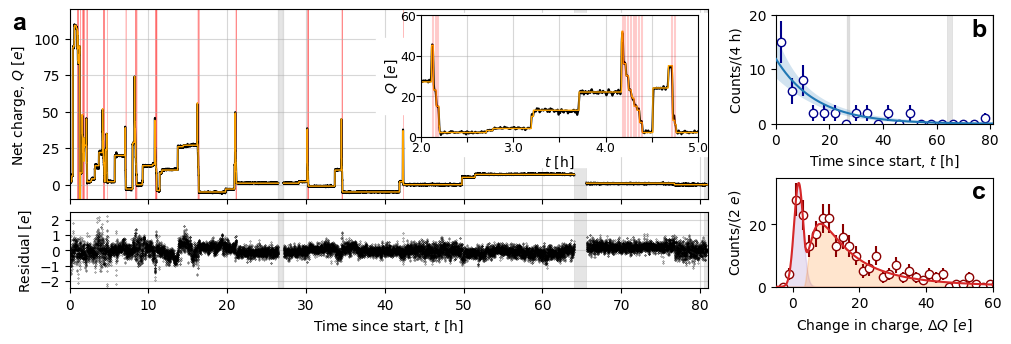

In [33]:
importlib.reload(bu)
recal = 1
init_charge = 10
fig = plt.figure(layout='constrained', figsize=(10, 3.33))
subfigs = fig.subfigures(1, 2, wspace=0.02, width_ratios=[2.5,1], hspace=0)
n_resamp = 2

axsLeft = subfigs[0].subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [2.5, 1], 'hspace': 0, 'wspace': 0})
t12 = 10.6
xv1, xv2 = 0, 81
time_vals = time_hours[1:]
filt_vec = corr_vec[1:,corr_idx]/cal_fac
filt_vec2 = gaussian_filter1d(filt_vec,n_resamp)

samps=2
for tt in dead_period_edges:
    st = np.argmin(np.abs(time_hours[1:]-tt[0]))-samps
    filt_vec2[st:(st+2*samps+1)] = np.nan
    running_charge[st:(st+2*samps+1)] = np.nan

axsLeft[0].plot(time_vals, filt_vec2, 'k-', label="Correlation", rasterized=True)
axsLeft[0].plot(time_vals, running_charge, '-', color='orange', label="Recon. charge", rasterized=True, lw=1)
axsLeft[0].text(-0.09, 0.99, "a", transform=axsLeft[0].transAxes, fontsize=18, fontweight='bold', va='top', ha='left', font="Arial")
plt.sca(axsLeft[0])
plt.gca().grid(True, alpha=0.5)
plt.ylim(-10,120)
bu.fill_dps(dead_period_edges)
bu.fill_dps(lamp_period_edges, 'blue', lab="UV lamp")

## filament not working before 0.9 hours for this sphere
bu.fill_dps(filament_period_edges, 'red', lab="Filament", line=False, start_time =0.9)
plt.ylabel("Net charge, $Q$ [$e$]")
plt.xlim(xv1, xv2)

inset_ax = axsLeft[0].inset_axes([0.55, 0.33, 0.435, 0.64])
inset_ax.plot(time_vals, filt_vec2, 'k-', label="Correlation", rasterized=True)
inset_ax.plot(time_vals, running_charge, '-', color='orange', label="Recon. charge", lw=1)
inset_ax.set_xlim(2,5)
inset_ax.set_ylim(0,60)
bu.fill_dps(filament_period_edges, 'red', lab="Filament", ax=inset_ax, line=True)
inset_ax.tick_params(axis='x', pad=0, labelsize=9)
inset_ax.tick_params(axis='y', pad=0, labelsize=9)
inset_ax.xaxis.labelpad = 0
inset_ax.yaxis.labelpad = 0
inset_ax.grid(True, alpha=0.5)
inset_ax.set_xlabel("$t$ [h]")
inset_ax.set_ylabel("$Q$ [$e$]")
inset_ax.set_xticklabels(['2.0', '', '3.0', '', '4.0', '', '5.0'])
rect = Rectangle((0.527,0.23), 0.55, 0.75, transform=axsLeft[0].transAxes, color='white', zorder=3)
axsLeft[0].add_patch(rect)

rect = Rectangle((0.7,0.17), 0.15, 0.1, transform=axsLeft[0].transAxes, color='white', zorder=3)
axsLeft[0].add_patch(rect)

rect = Rectangle((0.48,0.45), 0.05, 0.4, transform=axsLeft[0].transAxes, color='white', zorder=3)
axsLeft[0].add_patch(rect)

plt.sca(axsLeft[1])
resid = running_charge-filt_vec
resid2= gaussian_filter1d(resid,n_resamp)
axsLeft[1].plot(time_vals[::n_resamp], resid2[::n_resamp], 'k.', ms=0.5, rasterized=True)
plt.gca().grid(True, alpha=0.5)
plt.xlim(xv1, xv2)
plt.ylabel("Residual [$e$]")
plt.ylim(-2.5,2.5)
bu.fill_dps(dead_period_edges)
plt.gca().set_yticks([-2,-1,0,1,2])
plt.xlabel("Time since start, $t$ [h]")

axsMid = subfigs[1].subplots(2, 1)
plt.sca(axsMid[0])
plt.errorbar( bc_for_plot, hh_for_plot, yerr=np.sqrt(hh_for_plot), fmt='o', 
             markeredgecolor='darkblue', color='darkblue', markerfacecolor='white', label="Data")
curr_bp = params_from_profile[j]
xx = np.linspace(0,time_hours[-1],1000)

countour_mat = np.zeros((len(countour_vals), len(xx)))
for k,vert in enumerate(countour_vals):
    countour_mat[k,:] = np.log(2)*bin_length*vert[0]/vert[1] * 0.5**(xx/vert[1])

yy = np.log(2)*bin_length*curr_bp[0]/curr_bp[1] * 0.5**(xx/curr_bp[1])
ylo = np.min(countour_mat, axis=0)
yhi = np.max(countour_mat, axis=0)
print("best fit is: ", curr_bp )
print(curr_bp[1], curr_bp[1]-curr_bp[3], curr_bp[5]-curr_bp[1])

plt.plot(xx, yy, color='tab:blue', label="Fit +/- 1$\sigma$", zorder=10)
plt.fill_between(xx, ylo, yhi, color='tab:blue', alpha=0.2, edgecolor=None)
plt.ylim(0,20)
bu.fill_dps(dead_period_edges)
plt.xlabel("Time since start, $t$ [h]")
plt.ylabel("Counts/(%.0f h)"%(bin_length))

plt.xlim(xv1, xv2)

axsMid[0].text(0.97, 0.97, "b", transform=axsMid[0].transAxes, fontsize=18, fontweight='bold', va='top', ha='right', font="Arial")

plt.sca(axsMid[1])
change_data = all_charge_changes
binslo = np.arange(-4,20,2)
binshi = np.arange(20,int(1.1*np.max(change_data)),2)

bins = np.hstack((binslo, binshi))
hh, be = np.histogram(change_data, bins=bins)
bc = be[:-1] + np.diff(be)/2
bin_width = np.diff(be)

gpts = bc < 100
spars = [33.3,  1.83,  1.38, 30.8,  3.45, 11.9, 0.956]
sigma= np.sqrt(hh)
sigma[sigma==0] = 1
bp, bcov = opt.curve_fit(multigauss, bc[gpts], hh[gpts], sigma=sigma[gpts], p0=spars)
xx = np.linspace(-5, 100, 1000)

yy = 1.0*multigauss(xx, *bp)
yy[xx < 5] = 0
print("Best fit gauss mean: ", bp[1], np.sqrt(np.diag(bcov))[1])
print("Second peak location: ", xx[np.argmax(yy)])

bp_ln = bp.copy()
bp_ln[0] = 0
plt.errorbar(bc, hh, yerr=np.sqrt(hh), fmt='o', color='darkred', markerfacecolor='white')
plt.plot(xx, multigauss(xx, *bp), '-', color='tab:red', zorder=10)
plt.fill_between(xx, np.zeros_like(xx), gauss(xx, *bp[:3]), alpha=0.2, color='tab:purple')
plt.fill_between(xx, np.zeros_like(xx), multigauss(xx, *bp_ln), alpha=0.2, color='tab:orange')
plt.xlabel("Change in charge, $\Delta Q$ [$e$]")
plt.ylabel("Counts/(2 $e$)")
plt.ylim(0,35)
plt.xlim(-5,60)

axsMid[1].text(0.97, 0.98, "c", transform=axsMid[1].transAxes, fontsize=18, fontweight='bold', va='top', ha='right', font="Arial")

plt.savefig("charge_fig_paper.pdf", dpi=300, bbox_inches='tight')

plt.show()

Plot of the reconstructed impulse coincident with the charge change

In [34]:
import pickle

file_label = "20231030"
code_path = "/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/decay_analysis"
data_dir = os.path.join(code_path, "data", file_label)
with open(data_dir+"/pulse_plot_%s.pkl"%file_label, 'rb') as f:
    pulse_data = pickle.load(f)

for k in pulse_data.keys():
    print(k)
    exec("%s = pulse_data['%s']"%(k,k))


template_dict_fit
noise_dict_3D
cal_fac_fine
cal_fac_coarse
volts_per_meters
calibrated_OF_amps_from_fit
filt_bins_offset
data_list


In [35]:
## load calibration factors matching low pass filter used for plotting
calibrated_OF_amps_from_fit = np.load(data_dir + '/calibrated_OF_amps_from_fit_paper_plot_%s.npy'%file_label)

/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/decay_analysis/bead_utils.py:2759: RuntimeWarning: invalid value encountered in sqrt
  corr_data = np.sqrt(sp.filtfilt(b_lp, a_lp, np.abs(corr_data)**2))


232
232


/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/decay_analysis/bead_utils.py:2759: RuntimeWarning: invalid value encountered in sqrt
  corr_data = np.sqrt(sp.filtfilt(b_lp, a_lp, np.abs(corr_data)**2))
/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/decay_analysis/bead_utils.py:2761: RuntimeWarning: invalid value encountered in sqrt
  corr_data = np.sqrt(sp.filtfilt(b_lpz, a_lpz, np.abs(corr_data)**2))


232


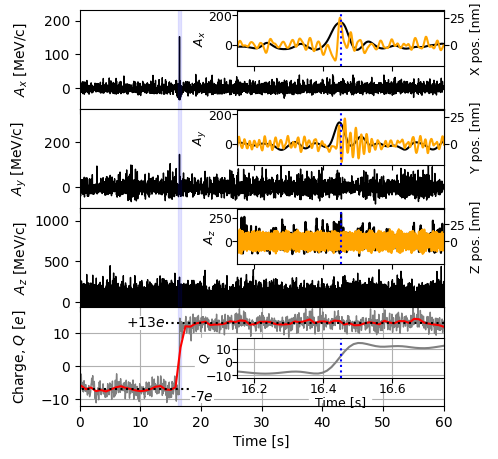

In [36]:
importlib.reload(bu)
cfile = 271 ## from 10/30/2023
cdat, attr, _ = bu.get_data(data_list[cfile])
yup = 75
xrange = [-1, -1]
charge_range = [-1, -1]
fig = plt.figure(figsize=(4.79, 4.5))
omega0, gamma = 2*np.pi*37.8, 2*np.pi*4.2
field_cal_fac_vec = [0.708, 0.763, 0.763]

_ = bu.plot_impulse_with_recon_3D(cdat, attr, template_dict_fit, noise_dict_3D, cal_facs=[cal_fac_fine, cal_fac_coarse], 
                                        amp_cal_facs=[volts_per_meters, calibrated_OF_amps_from_fit],
                                        filt_time_offset = filt_bins_offset, drive_idx=8, figout=fig,
                                        xrange=xrange, charge_range=charge_range, do_lowpass=True, ylim_init=[-15,58],
                                        toffset = 35, tmax=60, subtract_sine_step=False, res_pars=[omega0, gamma], filt_charge_data=True,
                                        field_cal_fac=field_cal_fac_vec, ylim2_scale=4, paper_plot=True, rasterized=True)

plt.figure(fig.number)
plt.savefig("pulse_fig_paper.pdf", dpi=300)

Separate plots of the above that may be useful for talks

/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/decay_analysis/bead_utils.py:2759: RuntimeWarning: invalid value encountered in sqrt
  corr_data = np.sqrt(sp.filtfilt(b_lp, a_lp, np.abs(corr_data)**2))
/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/decay_analysis/bead_utils.py:2759: RuntimeWarning: invalid value encountered in sqrt
  corr_data = np.sqrt(sp.filtfilt(b_lp, a_lp, np.abs(corr_data)**2))
/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/decay_analysis/bead_utils.py:2761: RuntimeWarning: invalid value encountered in sqrt
  corr_data = np.sqrt(sp.filtfilt(b_lpz, a_lpz, np.abs(corr_data)**2))
/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/decay_analysis/bead_utils.py:2759: RuntimeWarning: invalid value encountered in sqrt
  corr_data = np.sqrt(sp.filtfilt(b_lp, a_lp, np.abs(corr_data)**2))
/Users

232
232


/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/decay_analysis/bead_utils.py:2761: RuntimeWarning: invalid value encountered in sqrt
  corr_data = np.sqrt(sp.filtfilt(b_lpz, a_lpz, np.abs(corr_data)**2))


232


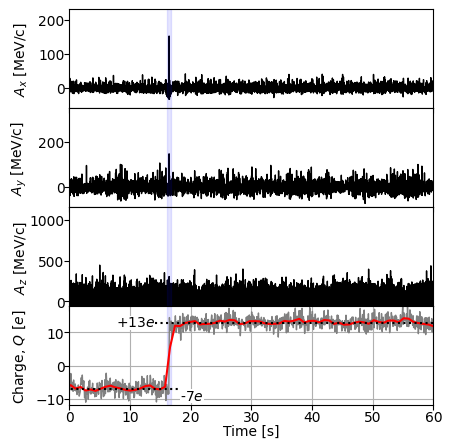

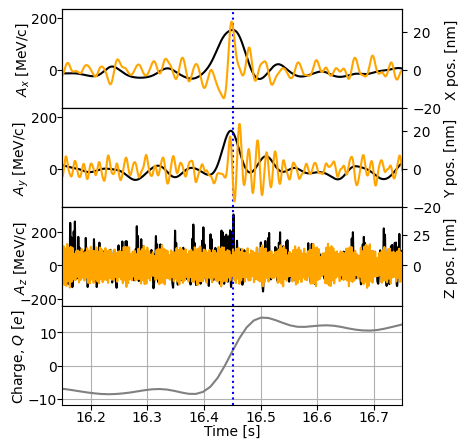

In [37]:
importlib.reload(bu)
cfile = 271 ## from 10/30/2023
cdat, attr, _ = bu.get_data(data_list[cfile])
yup = 75
xrange = [-1, -1]
charge_range = [-1, -1]
fig = plt.figure(figsize=(4.79, 4.5))
omega0, gamma = 2*np.pi*37.8, 2*np.pi*4.2
field_cal_fac_vec = [0.708, 0.763, 0.763]

_ = bu.plot_impulse_with_recon_3D(cdat, attr, template_dict_fit, noise_dict_3D, cal_facs=[cal_fac_fine, cal_fac_coarse], 
                                        amp_cal_facs=[volts_per_meters, calibrated_OF_amps_from_fit],
                                        filt_time_offset = filt_bins_offset, drive_idx=8, figout=fig,
                                        xrange=xrange, charge_range=charge_range, do_lowpass=True, ylim_init=[-15,58],
                                        toffset = 35, tmax=60, subtract_sine_step=False, res_pars=[omega0, gamma], filt_charge_data=True,
                                        field_cal_fac=field_cal_fac_vec, ylim2_scale=4, paper_plot=False, rasterized=True, col_to_use=[0])

plt.figure(fig.number)
plt.savefig("pulse_fig_no_inset.pdf", dpi=300) 

fig = plt.figure(figsize=(4.79, 4.5))
_ = bu.plot_impulse_with_recon_3D(cdat, attr, template_dict_fit, noise_dict_3D, cal_facs=[cal_fac_fine, cal_fac_coarse], 
                                        amp_cal_facs=[volts_per_meters, calibrated_OF_amps_from_fit],
                                        filt_time_offset = filt_bins_offset, drive_idx=8, figout=fig,
                                        xrange=xrange, charge_range=charge_range, do_lowpass=True, ylim_init=[-15,58],
                                        toffset = 35, tmax=60, subtract_sine_step=False, res_pars=[omega0, gamma], filt_charge_data=True,
                                        field_cal_fac=field_cal_fac_vec, ylim2_scale=4, paper_plot=False, rasterized=True, col_to_use=[1])

plt.figure(fig.number)
plt.savefig("pulse_fig_no_inset_zoom.pdf", dpi=300)

Plot of the recoil spectrum for all events

In [38]:
## We don't use 10/04 and 10/09 since they can't be calibrated
file_label_list = ["20230925", "20231030", "20231030_2", "20231121"]
pulse_data_list = []
for file_label in file_label_list:
    code_path = "/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/decay_analysis"
    data_dir = os.path.join(code_path, "data", file_label)
    fname_refined = data_dir+"/pulse_recon_no_sub_refined_%s.pkl"%(file_label)

    with open(fname_refined, 'rb') as fin:
        pulse_data_refined = pickle.load(fin)

    pulse_data_list.append(pulse_data_refined)


In [39]:
coord_list = ['x'] ## must be in order, not skipping any
bins = np.linspace(0, 600, 200)

tot_noise = np.zeros(len(bins[:-1]))

event_amps = []

for i,pulse_data_refined in enumerate(pulse_data_list):

    file_label = file_label_list[i]
    data_dir = os.path.join(code_path, "data", file_label)
    xtalk_fits = np.load(os.path.join(data_dir, "xtalk_fits_%s.npy"%file_label))
    y_to_x_row = np.where((xtalk_fits[:,-3] == 1) & (xtalk_fits[:,-2] == 0))[0][0]

    for j,k in enumerate(pulse_data_refined.keys()):
        amp = 0
        rand_recon = 0
        for m,c in enumerate(coord_list):
            amp += pulse_data_refined[k]['refined_OF_amps'][m]**2
            rand_recon += np.array(pulse_data_refined[k]['random_recon'][c])**2
        amp = np.sqrt(amp)
        amp_sub = np.abs(pulse_data_refined[k]['refined_x_amp_sub'])
        rand_recon = np.sqrt(rand_recon)
        ## now the histogram for random triggers from same events
        hh, be = np.histogram(rand_recon, bins=bins)
        bc = be[:-1] + np.diff(be)/2
        tot_noise += hh

        delta_Q = np.round(pulse_data_refined[k]['charge_after'] - pulse_data_refined[k]['charge_before'])

        event_amps.append([amp, amp_sub, delta_Q, k, pulse_data_refined[k]['prepulse_rms'][0], pulse_data_refined[k]['prepulse_pos_rms'][0], int(file_label_list[i])])

event_amps = np.array(event_amps)


Best fit pars:  [248.21150203   1.23839803]


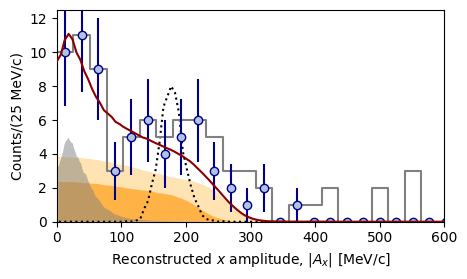

In [40]:
importlib.reload(bu)
field_cal_fac = 0.708 ## factor from COMSOL to convert to E-field at particle

rms = event_amps[:,4]  #**2 + event_amps[:,5]**2

b1, b2 = 40, 40
bins = np.linspace(0, 1000, b1)
bins2 = np.linspace(0, 1000, b2)
cut = event_amps[:,2] < 30
hh_nocut, be_nocut = np.histogram(event_amps[:,1]*field_cal_fac, bins=bins)   
bc_nocut = be_nocut[:-1] + np.diff(be_nocut)/2
hh, be = np.histogram(event_amps[cut,1]*field_cal_fac, bins=bins2)   
bc2 = be[:-1] + np.diff(be)/2
norm_fac = np.max(tot_noise)/4
tot_noise /= norm_fac

noise_vals = [40, 90, 200] 
exp_bins, epdf_ndof, epdf_1 = bu.calc_expected_spectrum(noise_vals, docut=False, make_plots=False)

alph = 0.3
plt.figure(figsize=(5,2.75))

## first the calibration peak
max_val = 8
calib_dat = np.load(os.path.join(code_path, "data", "20231121", "optimal_filter_amps_20231121.npz"))
plt.plot(calib_dat['bc']*field_cal_fac, calib_dat['hh']*max_val/np.max(calib_dat['hh']), 'k:')

path = "/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/alpha_recoils_Grimm/Sphere_Recoils_MC"
pdf_file = np.load(os.path.join(path, "recoil_sim_pdfs.npz"))

exp_bins = pdf_file['bins']
pdf_bi212, pdf_po212 = pdf_file['bi_pdf'], pdf_file['po_pdf']
tot_pdf = pdf_bi212 + pdf_po212



tot_pdf_ffn = lambda x,A,B: A*np.interp(x,exp_bins,tot_pdf, right=0) + B*np.interp(x,bc*field_cal_fac, tot_noise, right=0)

sigma = np.sqrt(hh)
sigma[sigma==0] = 1
bp, bcov = opt.curve_fit(tot_pdf_ffn, bc2, hh, p0=[1,0.5], sigma=sigma)
print("Best fit pars: ", bp)
plt.step(be_nocut[:-1], hh_nocut*b1/b2, where='post', color='gray')
plt.errorbar(bc2, hh, yerr=np.sqrt(hh), fmt='o', color='darkblue', markerfacecolor='lightsteelblue')
plt.fill_between(exp_bins, np.zeros_like(exp_bins), pdf_bi212*bp[0], color='darkorange', alpha=0.6, edgecolor=None) 
plt.fill_between(exp_bins, np.zeros_like(exp_bins), pdf_po212*bp[0], color='orange', alpha=0.3, edgecolor=None) 
plt.fill_between(bc*field_cal_fac, np.zeros_like(tot_noise), tot_noise*bp[1], color='gray', alpha=0.5, edgecolor=None)
xx = np.linspace(0, 600, 100)
plt.plot(xx, tot_pdf_ffn(xx, *bp), '-', color='darkred', zorder=3) 
plt.xlim(0,600)
plt.ylim(0,12.5)
plt.xlabel("Reconstructed $x$ amplitude, $|A_x|$ [MeV/c]")
plt.ylabel("Counts/(%d MeV/c)"%(bins2[1]-bins2[0]))

plt.savefig("spectrum_fig_paper.pdf", bbox_inches='tight')

============= Supplementary info plots start here ================

Plot of the calibration templates

In [41]:
## calibration templates

base_path = "/Volumes/DATA/"
sphere_data = ["20231017/1",
               "20231017/2",]

calib_data = ["20231017/calibration_1",]
calib_noise_path = ["20231017/calibration_1/noise",]

## create list of calibration files 
calib_file_dict = {}
coords_to_calib = ['x', 'y', 'z']

for curr_path in calib_data:

    for coord in coords_to_calib:
        fpath = os.path.join(base_path, curr_path, coord, "**MeV/*.h5")
        curr_file_list = natsorted(glob.glob(fpath, recursive=True))

        for file in curr_file_list:
            impulse_amp = bu.parse_impulse_amplitude(file)

            if( coord in calib_file_dict.keys()):            
                if impulse_amp in calib_file_dict[coord].keys():
                    calib_file_dict[coord][impulse_amp].append(file)
                else:
                    calib_file_dict[coord][impulse_amp] = [file,] 
            else:
                calib_file_dict[coord] = {}
                calib_file_dict[coord][impulse_amp] = [file,]

Max motion for 250 MeV [nm]:  18.080515150546578
Max motion for 250 MeV [nm]:  10.39093118607048
Max motion for 250 MeV [nm]:  2.535085463259124
[18.080515150546578, 10.39093118607048, 2.535085463259124]
0.2012049483508087
0.2008787143692102
0.20087453303141875


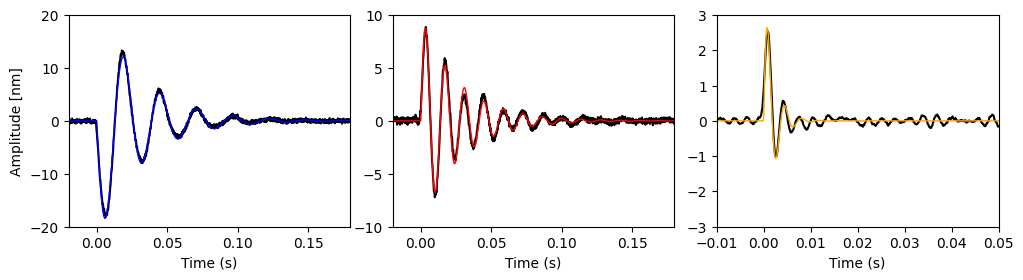

In [42]:

importlib.reload(bu)
fit_pars_dict = {'x': [-1,2*np.pi*30,10,0.20],
                 'y': [-1,2*np.pi*70,10,0.20],
                 'z': [-1,2*np.pi*120,30,0.20]}
## plot with smaller x range
template_dict, template_dict_fit, fit_vals, norm_dict = bu.get_average_template_3D(calib_file_dict, make_plots=True,
                                                                        fit_pars=fit_pars_dict, drive_idx=10)
plt.close('all')

## using the above, we can calibrate into volts per meters
volts_per_meters = {}
MeV_to_kgms = 5.34e-22 ## 1 MeV in kg*m/s
msphere = 2.5e-14 ## 2.8 um sphere @ 2,0 g/cm^3 in kg
nlist = []
coord_list = ['x', 'y', 'z']
for coord in coord_list:
    fp = fit_vals[coord][coord]
    omega0, gam = fp[1], fp[2]
    omega1 = np.sqrt( omega0**2 - gam**2 )
    t = np.linspace(0, 10/(omega0/(2*np.pi)), 1000) ## 10 periods
    p0 = norm_dict[coord + "_amp"] * MeV_to_kgms
    volts_per_meters[coord] = norm_dict[coord]/(p0*np.max(np.exp(-gam*t)*np.sin(omega1*t))/(msphere*omega1))
    #print(volts_per_meters[coord])
    n1 = p0*np.max(np.exp(-gam*t)*np.sin(omega1*t))/(msphere*omega1)*1e9
    print("Max motion for 250 MeV [nm]: ", n1)
    nlist.append(n1)
print(nlist)

fig = bu.get_average_template_paper(calib_file_dict, make_plots=True, fit_pars=fit_pars_dict, drive_idx=10, 
                                    norm_vals = nlist, xrange=[-0.02, 0.18], ylims=[20,10,3])

plt.savefig("impulse_response.pdf", bbox_inches='tight')

Fit parameter latex table

In [43]:
coord_list = ['x', 'y', 'z']
print("Coord. \t & $f_0$ [Hz] & $\gamma/(2\pi)$ [Hz] \\\\")
print("\hline")
for coord in coord_list:
    fp = fit_vals[coord][coord]
    print("$%s$ & \t$%.2f\pm %.2f$ &\t $%.1f\pm%.1f$ \\\\"%(coord, fp[1]/(2*np.pi), fp[5]/(2*np.pi), fp[2]/(2*np.pi), fp[6]/(2*np.pi)))

Coord. 	 & $f_0$ [Hz] & $\gamma/(2\pi)$ [Hz] \\
\hline
$x$ & 	$38.72\pm 0.02$ &	 $5.2\pm0.0$ \\
$y$ & 	$72.41\pm 0.16$ &	 $5.9\pm0.2$ \\
$z$ & 	$274.10\pm 1.57$ &	 $78.7\pm2.0$ \\


Plot of noise spectra

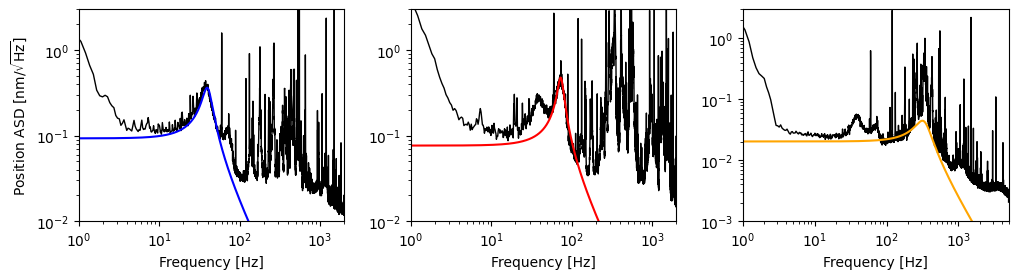

In [44]:
noise_file_list = []
for curr_path in calib_noise_path:
    curr_file_list = natsorted(glob.glob(os.path.join(base_path, curr_path, "*.h5"), recursive=True))
    if(len(noise_file_list)>0):
        noise_file_list.append(curr_file_list)
    else:
        noise_file_list = curr_file_list

importlib.reload(bu)

range_dict = {'x': [5,2e3], 'y': [5,2e3], 'z': [50, 5e3]}
yld = {'x': [1e-2, 3e0], 'y': [1e-2, 3e0], 'z': [1e-3, 3e0]}

noise_dict_3D = bu.plot_noise_paper(noise_file_list[:5], fit_vals, range_dict=range_dict, ylim_dict=yld, nfft=2**16, cal=volts_per_meters)
plt.savefig("noise_fig_paper.pdf", bbox_inches='tight')

Plot of Bi-Tl coincidence

In [45]:
file_label = "20231030"
code_path = "/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/decay_analysis"
data_dir = os.path.join(code_path, "data", file_label)
with open(data_dir+"/pulse_plot_%s.pkl"%file_label, 'rb') as f:
    pulse_data = pickle.load(f)

for k in pulse_data.keys():
    print(k)
    exec("%s = pulse_data['%s']"%(k,k))

fname_nosub = data_dir+"/pulse_recon_no_sub_%s.pkl"%(file_label)
with open(fname_nosub, 'rb') as fin:
    pulse_data = pickle.load(fin)

template_dict_fit
noise_dict_3D
cal_fac_fine
cal_fac_coarse
volts_per_meters
calibrated_OF_amps_from_fit
filt_bins_offset
data_list


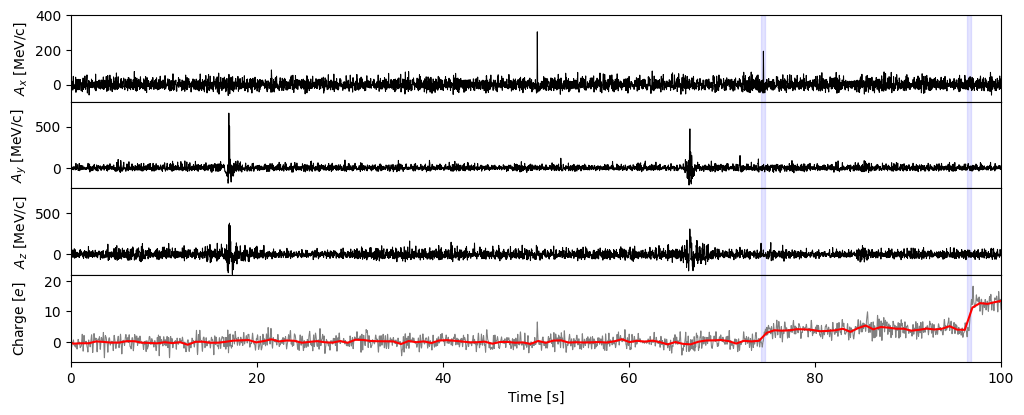

In [46]:
importlib.reload(bu)
## noise pulses in file 249
ylims = {'x': [-100, 400], 'y': [-250, 800], 'z': [-250, 800]}
k=249
field_cal_fac = 0.708 ## x direction
fig = bu.pulse_recon_paper(pulse_data[k], template_dict=template_dict_fit, noise_dict=noise_dict_3D, 
                                amp_cal_facs=[volts_per_meters, calibrated_OF_amps_from_fit*field_cal_fac], do_bandpass=True, xrange=[3, 103], ylims=ylims,
                                charge_times=[74.45, 96.6])

plt.savefig("bi_tl_fig_paper.pdf", dpi=300, bbox_inches='tight')

Plot of subtraction of impulse from example waveform

In [47]:
## load calibration factors matching low pass filter used for plotting
calibrated_OF_amps_from_fit = np.load(data_dir + '/calibrated_OF_amps_from_fit_paper_plot_%s.npy'%file_label)

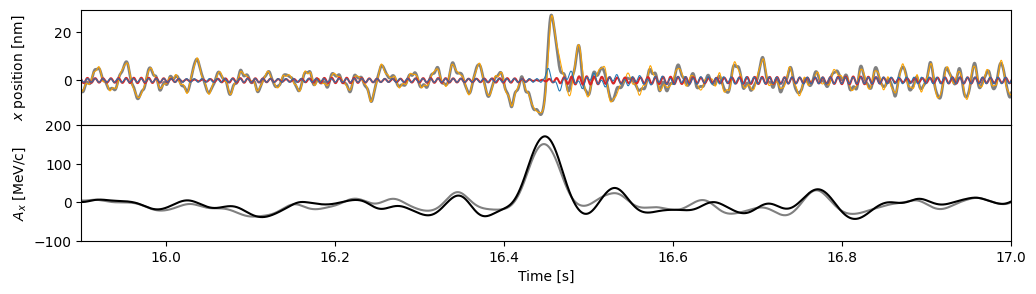

In [48]:
## sine subtraction plot
file_label = "20231030"
importlib.reload(bu)
with open(data_dir+"/template_fit_vals_%s.pkl"%file_label, 'rb') as handle:
    fit_vals = pickle.load(handle)
    
## noise pulses in file 249
ylims = {'x': [-100, 500], 'y': [-350, 1000], 'z': [-350, 1000]}
k=271
fig = bu.sine_subtraction_paper(pulse_data[k], fit_vals, template_dict=template_dict_fit, noise_dict=noise_dict_3D, 
                                amp_cal_facs=[volts_per_meters, calibrated_OF_amps_from_fit*field_cal_fac], do_bandpass=True, xrange=[35,95], ylims=ylims,
                                charge_times=[], xzoom=[15.9,17])
plt.savefig("sine_sub_paper.pdf", bbox_inches='tight')

Reconstruction methods plots

In [49]:
file_label = "20231017"
code_path = "/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/decay_analysis"
data_dir = os.path.join(code_path, "data", file_label)
with open(data_dir+"/calib_data_%s.pkl"%file_label, 'rb') as f:
    calib_data = pickle.load(f)

for k in calib_data.keys():
    print(k)
    exec("%s = calib_data['%s']"%(k,k))

time_corr_amps
bandpass_amps
opt_filt_amps_1D
time_corr_amps_ped
bandpass_amps_ped
opt_filt_amps_1D_ped
opt_filt_amps_1D_y
opt_filt_amps_1D_z


177.0 Time fit, sig	=23.5 +/- 0.5
177.0 Bandpass, sig	=19.2 +/- 0.3
177.0 Opt. filt., sig	=15.1 +/- 0.2
$x$, sig	=15.1 +/- 0.2
$y$, sig	=37.7 +/- 0.6
$z$, sig	=63.1 +/- 1.8


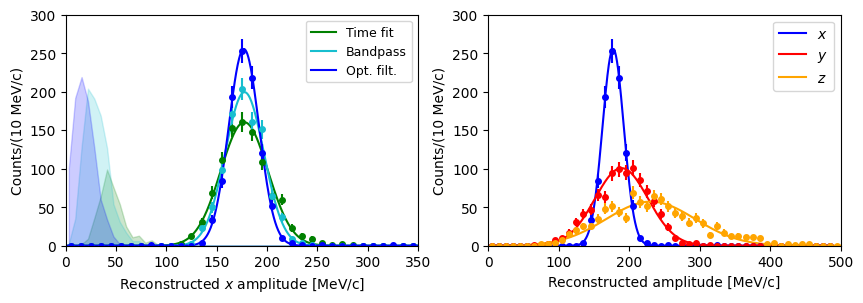

In [50]:
## compare various recon methods
amp_bins = np.arange(0,100,1.5)

def gauss_fun(x,A,mu,sig):
    return A*np.exp(-(x-mu)**2/(2*sig**2))

fit_vals_amps_orig = []

amp_dicts = [time_corr_amps, bandpass_amps, opt_filt_amps_1D] #, opt_filt_amps_1D_lp_filt]
ped_dicts = [time_corr_amps_ped, bandpass_amps_ped, opt_filt_amps_1D_ped] #, opt_filt_amps_1D_lp_filt
amp_methods = ["Time fit", "Bandpass", "Opt. filt."]
amp_cal_facs = [106.8, 6889, 1.057e-5, 1.057e-5, 1.057e-5, 1.057e-5] ## set by hand to match the calibration data  ##91.2, 
amp_colors = ['g', 'tab:cyan', 'b']

ymax = 300

## account for COMSOL field ratio, column 10
field_cal_fac = 0.708

plt.figure(figsize=(10,3))    
plt.subplot(1,2,1)
for i,filt_amps in enumerate(amp_dicts):

    for j,amp in enumerate(filt_amps.keys()):
        if( not isinstance(amp, numbers.Number)): continue
        amp_bins = np.arange(0,2*amp,10)
        ca = filt_amps[amp]*amp_cal_facs[i]
        gpts = (ca>0)
        amp_scale = amp*field_cal_fac/np.median(ca[gpts])
        hh,be = np.histogram(ca*amp_scale, bins=amp_bins)
        bc = be[:-1] + np.diff(be)/2

        ## gauss fit
        err = np.sqrt(hh)
        err[err==0] = 1
        gp, gcov = opt.curve_fit(gauss_fun, bc, hh, sigma=err, p0=[1, amp, 50])

        ## amplitude, mean, mean_err, sig, sig_err
        fit_vals_amps_orig.append([amp, gp[1], np.sqrt(gcov[1,1]), np.abs(gp[2]), np.sqrt(gcov[2,2]), i])
        xx = np.linspace(0, bc[-1],1000)
        plt.errorbar(bc, hh, yerr=np.sqrt(hh), fmt='o', color=amp_colors[i], ms=4)
        plt.plot(xx, gauss_fun(xx, *gp), amp_colors[i], label=amp_methods[i])
        plt.ylabel("Counts/(%d MeV/c)"%(bc[1]-bc[0]))
        plt.xlabel("Reconstructed $x$ amplitude [MeV/c]")

        print(amp*field_cal_fac, "%s, sig\t=%.1f +/- %.1f"%(amp_methods[i], gp[2], np.sqrt(gcov[2,2])))

        if(len(ped_dicts[i]) > 0):
            amp_bins = np.linspace(0,2*amp,80)
            ca = ped_dicts[i][amp]*amp_cal_facs[i]*amp_scale
            hh,be = np.histogram(ca, bins=amp_bins)
            bc = be[:-1] + np.diff(be)/2
            plt.fill_between(bc, np.zeros_like(bc), hh, color=amp_colors[i], alpha=0.2, edgecolor=amp_colors[i])

        plt.legend(fontsize=9)

    plt.xlim(0,350)
    plt.ylim(0,ymax)

field_cal_fac_vec = [0.708, 0.763, 0.763]
plt.subplot(1,2,2)
amp_dicts = [opt_filt_amps_1D, opt_filt_amps_1D_y, opt_filt_amps_1D_z]
amp_methods = ["$x$", "$y$", "$z$"]
amp_cal_facs = [1.057e-5, 3.76e-5, 4.71e-5] 
amp_colors = ['b', 'r', 'orange', 'g']

for i,filt_amps in enumerate(amp_dicts):

    for j,amp in enumerate(list(filt_amps.keys())[:1]):
        if( not isinstance(amp, numbers.Number)): continue
        amp_bins = np.arange(0,2*amp,10)
        ca = filt_amps[amp]*amp_cal_facs[i]
        gpts = (ca>0)
        amp_scale = amp*field_cal_fac_vec[i]/np.median(ca[gpts])
        hh,be = np.histogram(ca*amp_scale, bins=amp_bins)
        bc = be[:-1] + np.diff(be)/2

        ## gauss fit
        err = np.sqrt(hh)
        err[err==0] = 1
        gp, gcov = opt.curve_fit(gauss_fun, bc, hh, sigma=err, p0=[1, amp, 50])

        ## amplitude, mean, mean_err, sig, sig_err
        fit_vals_amps_orig.append([amp, gp[1], np.sqrt(gcov[1,1]), np.abs(gp[2]), np.sqrt(gcov[2,2]), i])

        xx = np.linspace(0, bc[-1],1000)
        plt.errorbar(bc, hh, yerr=np.sqrt(hh), fmt='o', color=amp_colors[i], ms=4)
        plt.plot(xx, gauss_fun(xx, *gp), amp_colors[i], label=amp_methods[i])
        plt.ylabel("Counts/(%d MeV/c)"%(bc[1]-bc[0]))
        plt.xlabel("Reconstructed amplitude [MeV/c]")

        print("%s, sig\t=%.1f +/- %.1f"%(amp_methods[i], gp[2], np.sqrt(gcov[2,2])))
        
        plt.legend(fontsize=10)

    plt.xlim(0,500)
    plt.ylim(0,ymax)

plt.savefig("recon_comparison.pdf", bbox_inches='tight')

Electric field plots

In [51]:
## e field plot
import pandas as pd

data_path = "/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/decay_paper"

flist = ["efield_central.txt", "efield_upper.txt", "efield_lower.txt"]

all_sorted_dfs = []
for f in flist:
    df = pd.read_csv(os.path.join(data_path, f), delimiter='\s+', skiprows=8)
    sorted_df = df.sort_values(by='x')

    all_sorted_dfs.append(sorted_df)

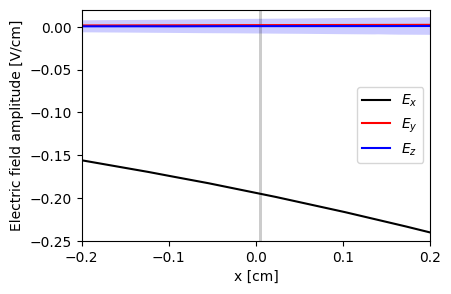

In [52]:
m_to_cm = 1e2
m_to_mm = 1e3

plt.figure(figsize=(4.5,3))

sorted_df = all_sorted_dfs[0]

plt.plot(sorted_df['x']*m_to_cm, (sorted_df[sorted_df.columns[3]]), 'k', label="$E_x$")
plt.plot(sorted_df['x']*m_to_cm, (sorted_df[sorted_df.columns[5]]), 'r', label="$E_y$")
plt.plot(sorted_df['x']*m_to_cm, (sorted_df[sorted_df.columns[4]]), 'b', label="$E_z$")

sorted_df_lower = all_sorted_dfs[2]
sorted_df_upper = all_sorted_dfs[1]
upper_vals = np.interp(sorted_df_lower['x'], sorted_df_upper['x'], (sorted_df_upper[sorted_df_upper.columns[3]]) )
plt.fill_between(sorted_df_lower['x']*m_to_cm, (sorted_df_lower[sorted_df_lower.columns[3]]), upper_vals, color='k', alpha=0.2, edgecolor=None)

upper_vals = np.interp(sorted_df_lower['x'], sorted_df_upper['x'], (sorted_df_upper[sorted_df_upper.columns[5]]) )
plt.fill_between(sorted_df_lower['x']*m_to_cm,(sorted_df_lower[sorted_df_lower.columns[5]]), upper_vals, color='r', alpha=0.2, edgecolor=None)

upper_vals = np.interp(sorted_df_lower['x'], sorted_df_upper['x'], (sorted_df_upper[sorted_df_upper.columns[4]]) )
plt.fill_between(sorted_df_lower['x']*m_to_cm, (sorted_df_lower[sorted_df_lower.columns[4]]), upper_vals, color='b', alpha=0.2, edgecolor=None)

y1, y2 = -0.25, 0.02
plt.fill_between([0.003, 0.007], [y1, y1], [y2, y2], color='k', alpha=0.2, edgecolor=None)

plt.gca().set_xticks([-0.2, -0.1, 0, 0.1, 0.2])

plt.legend() 
plt.xlim(-0.2, 0.2)
plt.ylim(y1, y2)
plt.xlabel("x [cm]")
plt.ylabel("Electric field amplitude [V/cm]")

plt.savefig("efield_1dsim.pdf", bbox_inches='tight')    